# Homework - Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import ArrayLike
from typing import Any, Literal

RANDOM_SEED = 42

## Getting the data
The dataset used was the California Housing Prices from Kaggle, which can be found [here](https://www.kaggle.com/datasets/camnugent/california-housing-prices?resource=download&select=housing.csv).

In [2]:
df = pd.read_csv("../data/housing.csv.zip")
df.drop("ocean_proximity", axis=1, inplace=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


## EDA

In [3]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Taking a quick look on the "median_house_value" variable

In [4]:
def plot_hist(data: ArrayLike, title: str, xlabel: str, nbins: int = None):
    plt.figure(figsize=(10, 6))
    plt.axes(frame_on=False)
    if nbins:
        n, bins, edges = plt.hist(data, edgecolor="black", zorder=3, bins=nbins)
    else:
        n, bins, edges = plt.hist(data, edgecolor="black", zorder=3)
    plt.axvline(np.median(data), zorder=4, color="red", label="Median = {}".format(np.median(data)))
    plt.title(title)
    plt.xlabel(xlabel)
    if (nbins and nbins <= 13) or not nbins:
        plt.xticks(bins)
        for freq, value in zip(n, bins):
            plt.text(value + ((bins[1] - bins[0]) / 2), int(freq), freq, va="bottom", ha="center")
            plt.tick_params(left=False, labelleft=False)
    else:
        plt.grid(axis="y", zorder=1)
        plt.ylabel("Frequency")
    plt.legend()
    plt.show()

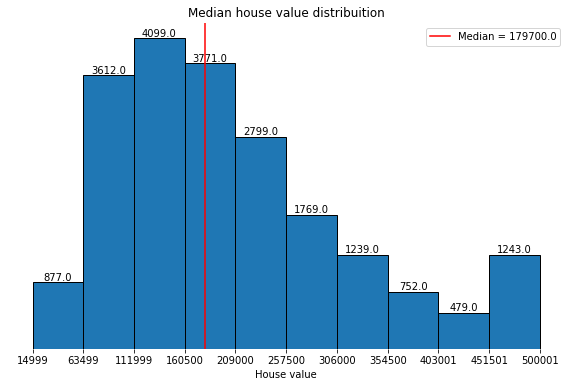

In [5]:
plot_hist(df["median_house_value"], "Median house value distribuition", "House value")

It has a somewhat long tail to the right. The median line makes it easy to compare, because it splits the data in half taking the order in consideration. Half of the data is concentrated in less than 179.700 aproximatedly. The right side has more bins, which means they have bigger values, but are more sparse. Data that present some kind of tail tend to posess more outliers, which will negatively impact the performance of the models.

If applied logarithmic transformation to this variable we will have the following:

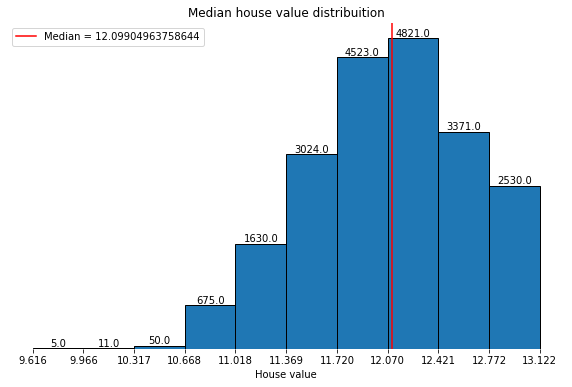

In [6]:
x = np.log1p(df["median_house_value"])

plot_hist(x, "Median house value distribuition", "House value")

With this transformation we brought the data closer to a normal distribuition, which is close to ideal format to work with models.

## Question 1
Find a feature with missing values. How many missing values does it have?

In [7]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Question 2
What's the median (50% percentile) for variable 'population'?

In [8]:
df.population.median()

1166.0

## Splitting the data


In [9]:
def train_val_test_split(data: pd.DataFrame, seed: int) -> "list[Any | list | pd.DataFrame]":
    """Splits the dataset into train, validation and test subsets.

    Args:
        data (pd.DataFrame): input data that will be splitted.
        seed (int): random seed that will control the shuffling.

    Returns:
        list[Any | list | pd.DataFrame]: A list containint train-validation-test splits of the input.
    """
    np.random.seed(seed)

    n = len(data)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = data.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy().reset_index(drop=True)
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy().reset_index(drop=True)
    df_test = df_shuffled.iloc[n_train+n_val:].copy().reset_index(drop=True)
    
    y_train = np.log1p(df_train["median_house_value"].values)
    y_val = np.log1p(df_val["median_house_value"].values)
    y_test = np.log1p(df_test["median_house_value"].values)

    return [df_train, df_val, df_test, y_train, y_val, y_test]

In [10]:
df_train, df_val, df_test, y_train, y_val, y_test = train_val_test_split(df, RANDOM_SEED)

## Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [11]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [12]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [13]:
def preprocess(data: pd.DataFrame, fillna_strategy: Literal["zero", "mean"]) -> pd.DataFrame:
    """Transforms the data filling N/A values according to the chosen strategy.

    Args:
        data (pd.DataFrame): input data.
        fillna_strategy: the method that will fill null values in the dataset. Possible values are \"zero\" or \"mean\" only.

    Raises:
        ValueError: the strategy chosen is not zero or mean.

    Returns:
        pd.DataFrame: the transformed data.
    """
    if fillna_strategy not in ["zero", "mean"]: 
        raise ValueError("Only 'zero' and 'mean' values are valid for fillna strategy")
    
    result = data.drop("median_house_value", axis=1)
    if fillna_strategy == "zero":
        result.fillna(0, inplace=True)
    elif fillna_strategy == "mean":
        result.fillna(result["total_bedrooms"].mean(), inplace=True)
    return result

### Filling null values with 0

In [14]:
X_train_fill_0 = preprocess(df_train, "zero")
w_0_fill_0, w_fill_0 = train_linear_regression(X_train_fill_0, y_train)

X_valid_fill_0 = preprocess(df_val, "zero")
y_pred_fill_0_val = w_0_fill_0 + X_valid_fill_0.dot(w_fill_0)

print(f"RMSE score when filling missing values with 0: {rmse(y_val, y_pred_fill_0_val):.2f}")

RMSE score when filling missing values with 0: 0.33


### Filling null values with mean

In [15]:
X_train_fill_mean = preprocess(df_train, "mean")
w_0_fill_mean, w_fill_mean = train_linear_regression(X_train_fill_mean, y_train)

X_valid_fill_mean = preprocess(df_val, "mean")
y_pred_fill_mean_val = w_0_fill_mean + X_valid_fill_mean.dot(w_fill_mean)

print(f"RMSE score when filling missing values with mean: {rmse(y_val, y_pred_fill_mean_val):.2f}")

RMSE score when filling missing values with mean: 0.33


After analyzing the RMSE scores of the validation data for the two different filling methods, it is possible to conclude that both are equally good.

## Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which `r` gives the best RMSE?

In [16]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r + np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [17]:
X_train_reg = preprocess(df_train, "zero")
X_val_reg = preprocess(df_val, "zero")

r = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

for reg_value in r:
    w0, w = train_linear_regression_reg(X_train_reg, y_train, reg_value)
    y_pred = w0 + X_val_reg.dot(w)
    print(f"RMSE score when filling values with zero and choosing r = {reg_value} " +
          f"for regularization: {rmse(y_val, y_pred):.2f}")


RMSE score when filling values with zero and choosing r = 0 for regularization: 0.33
RMSE score when filling values with zero and choosing r = 1e-06 for regularization: 0.33
RMSE score when filling values with zero and choosing r = 0.0001 for regularization: 0.33
RMSE score when filling values with zero and choosing r = 0.001 for regularization: 0.33
RMSE score when filling values with zero and choosing r = 0.01 for regularization: 0.33
RMSE score when filling values with zero and choosing r = 0.1 for regularization: 0.33
RMSE score when filling values with zero and choosing r = 1 for regularization: 0.34
RMSE score when filling values with zero and choosing r = 5 for regularization: 0.34
RMSE score when filling values with zero and choosing r = 10 for regularization: 0.34


## Question 5
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
- Round the result to 3 decimal digits (`round(std, 3)`)

In [18]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

for seed_value in seeds:
    df_train, df_val, df_test, y_train, y_val, y_test = train_val_test_split(df, seed_value)

    X_train = preprocess(df_train, "zero")
    X_val = preprocess(df_val, "zero")
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)

    rmse_scores.append(rmse(y_val, y_pred))

print(round(np.std(rmse_scores), 3))

0.004


## Question 6
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [19]:
df_train, df_val, df_test, y_train, y_val, y_test = train_val_test_split(df, 9)

df_full = pd.concat([df_train, df_val]).reset_index(drop=True)
y_full = np.concatenate([y_train, y_val])

X_train = preprocess(df_full, "zero")
X_test = preprocess(df_test, "zero")

w0, w = train_linear_regression_reg(X_train, y_full, 0.001)
y_pred = w0 + X_test.dot(w)

rmse(y_test, y_pred)

0.3493283020122639